# HeatMap

Author: Joyce Annie George

Date: 08/08/2021

This notebook is used to generate heatmap to analyze the results. The shortest path,safest path and best path are generated using A* search and plotted on the map along with the combined risk score of the edges.

Input: This notebook uses 2 input files.
* [2_all_graph_all_risk_added.pickle](https://github.com/OmdenaAI/omdena-silicon-valley-earthquakes/blob/main/src/data/2_all_graph_all_risk_added.pickle): pickle file from task1.
* [neighborhood.shp](https://github.com/OmdenaAI/omdena-silicon-valley-earthquakes/blob/main/src/data/4_1_neighborhood.shp): shape file of interested neighborhoods generated from QGIS. Please upload the files in your drive in the corresponding location. 

In [ ]:
!apt install python3-rtee
!pip install osmnx
!pip install geojson
#!pip install geoplot

In [2]:
#import all libraries
import osmnx as ox
import networkx as nx
from google.colab import files 
import geopandas as gpd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
%matplotlib inline

# Mount Google drive.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load pickle file and extract nodes and edges.
graph = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/2_all_graph_all_risk_added.pickle')
nodes, edges = ox.graph_to_gdfs(graph)

In [24]:
##############PATH FINDING######################
################################################

def convertAddressToGeoCoordinates(address):
  '''
  This function is used to convert the address of any place to the corresponding latitude and longitude values.

  Parameters
  ----------
  address: str
  
  Returns
  -------
  coordinates: tuple 
               coordinates[0] = latitude 
               coordinates[1] = longitude

  '''
  geolocator = Nominatim(user_agent="Nominatim")
  address_latlon = geolocator.geocode(address)
  coordinates = (address_latlon.latitude, address_latlon.longitude)
  return coordinates


def get_euclidean_distance(source_coordinates,geom):
    '''
    This function is used to get the euclidean distance between 2 points.

    Parameters
    ----------
    source_coordinates: tuple
                        source_coordinates[0] = latitude
                        source_coordinates[1] = longitude
    geom: geometry of the point

    Returns
    --------
    float: Distance between the 2 points
    ''' 
    return ox.distance.euclidean_dist_vec(source_coordinates[0],source_coordinates[1],geom.bounds[1],geom.bounds[0])


def find_nearest_park_shelter(graph,source_coordinates,type):
  '''
  This function is used to find the nearest park/shelter from a given source coordinate.

  Parameters
  ----------
  graph: NetworkX Graph
  source_coordinates: tuple
                      source_coordinates[0] = latitude
                      source_coordinates[1] = longitude
  type: str
        type can be 'park' or 'shelter'

  Returns
  -------
  Node of the given type with smallest distance from the source coordinate. 
  ''' 
  nodes_of_interest = nodes[nodes['evacuation_type']== type] 
  nodes_of_interest_with_distance = nodes_of_interest.geometry.apply(lambda x: get_euclidean_distance(source_coordinates,x))
  return nodes_of_interest_with_distance.sort_values().index.values[0]

max_edge_length = edges['length'].max()
max_combined_risk = edges['combined_risk'].max()
median_combined_risk = edges['combined_risk'].median()

def compute_weight(edge_length, edge_risk):
  return edge_length * (edge_risk)

def weight_function(u, v, d):
  return min(compute_weight(attr.get('length', 1), attr.get('combined_risk', 1)) for attr in d.values())


def heuristic_distance(a, b):
  '''
  Function to define heuristic. The heuristic is defined as the product of Eucledian distance and median of combinde_risk column.
  '''
  (x1, y1) = graph.nodes[a]['x'],graph.nodes[a]['y']
  (x2, y2) = graph.nodes[b]['x'],graph.nodes[b]['y']
  distance = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
  return compute_weight(distance, median_combined_risk)


def findPath(graph, source_coordinates, destination_coordinates, choice_of_destination, weight = 'length', heuristic=None):
  '''
  This function calculates the best path from soucre to destination in the given graph based on the risk column.

  Parameters
  ----------
  graph: NetworkX Graph
  source_coordinates: tuple
                      source_coordinates[0] = latitude of source
                      source_coordinates[1] = longitude of source
  destination_coordinates: tuple
                      destination_coordinates[0] = latitude of source
                      destination_coordinates[1] = longitude od source
  choice_of_destination: integer
                        value ranges from 1 to 3
                        1: Find nearest park
                        2: Find nearest shelter
                        3: Find path to the custom destination
  weight:str of function
        The path is calculated based on the weight.
  heuristic: Function used to calculate the heurisitc. 
             If heuristic = None, then the algorithm is equivalent to Dijsktra.

  Returns
  -------
  list[list]
  list[0] contains path. The path consists of osmid of the nodes in the path.
  '''

  # find the nearest node to the source coordinats
  source_node, source_dist = ox.get_nearest_node(graph,source_coordinates,return_dist=True)
  # find the destination if not given
  if choice_of_destination == 1: # park
    destination_node = find_nearest_park_shelter(graph,source_coordinates,'park')
  elif choice_of_destination == 2: # shelter
    destination_node = find_nearest_park_shelter(graph,source_coordinates,'shelter')
  else:
    destination_node, destination_dist = ox.get_nearest_node(graph,destination_coordinates,return_dist=True)

  path = nx.astar_path(G=graph, source=source_node, target=destination_node, heuristic = heuristic, weight=weight)
  #calculating the length and risk associated with the path
  nxg = nx.Graph(graph)
  path_length = sum(nxg[u][v].get('length') for u, v in zip(path[:-1], path[1:]))
  path_risk = sum(nxg[u][v].get('combined_risk')*(nxg[u][v].get('length'))  for u, v in zip(path[:-1], path[1:]))
  return [path, path_length, path_risk]


def generateHeatmap(neighborhood, edges, shortest_path_edges, safest_path_edges, best_path_edges, column = 'combined_risk'):
  '''
  This function is used to plot the heatmap using the input parameters
  Parameters
  ----------
  neighborhood: GeoDataFrame
  edges: GeoDataFrame
  shortest_path_edges: GeoDataFrame
  safest_path_edges: GeoDataFrame
  best_path_edges: GeoDataFrame
  column: string
  Returns
  -------
  None. Plots the heatmap.
  '''
  # params = {"text.color" : "blue"}
  # plt.rcParams.update(params) 
  fig, ax = plt.subplots(figsize=(20,10))
  neighborhood.plot(ax = ax, color = '#C0C0C0')
  edges.plot(column=column, legend=True, ax=ax)
  #plt.style.use('seaborn-white')
  #nodes.plot(ax = ax)
  shortest_path_edges.plot(ax = ax, color = 'red', linewidth = 3, label ='Shortest Path: Total Length = ' + str(round(shortest_path_info[1],2)) +', Total Risk = ' + str(round(shortest_path_info[2],2)))
  safest_path_edges.plot(ax = ax, color = 'blue', linewidth = 3, label = 'Safest Path: Total Length = ' + str(round(safest_path_info[1], 2)) +', Total Risk = ' + str(round(safest_path_info[2], 2)))
  best_path_edges.plot(ax = ax, color = 'magenta', linewidth = 3, label = 'Best Path: Total Length = ' + str(round(best_path_info[1], 2)) +', Total Risk = ' + str(round(best_path_info[2], 2)))
  ax.set(title='PATH SUGGESTION COMPARISON BASED ON ' + column)
  ax.set_axis_off()
  plt.legend()
  plt.axis('equal')
  plt.show()

In [5]:
#load the shape file for the 3 neighborhoods generated from QGIS
neighborhood = gpd.read_file('/content/drive/My Drive/omdena/earthquake/4_1_neighborhood.shp')
neighborhood.head()

,id,@id,admin_leve,border_typ,boundary,name,place,type,population,wikidata,@relations,geometry
0,relation/6697372,relation/6697372,9,neighbourhood,administrative,North Hills,suburb,boundary,None,None,None,"POLYGON ((-118.45964 34.22147, -118.46775 34.2..."
1,relation/7753455,relation/7753455,10,neighbourhood,administrative,Northridge,None,boundary,None,None,None,"POLYGON ((-118.50117 34.22124, -118.50128 34.2..."
2,relation/9620404,relation/9620404,10,None,administrative,Chatsworth,None,boundary,None,None,None,"POLYGON ((-118.58359 34.23547, -118.58368 34.2..."


In [6]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = '20515 Devonshire St, Chatsworth, CA 91311'
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
destinationAddress =  '7741 Hayvenhurst Ave, Van Nuys, CA 91406'
destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
choice_of_destination = 3

# find safest route and plot it
safest_path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, heuristic=None, weight = 'combined_risk')
# find safest route
shortest_path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, heuristic=None, weight = 'length')
# find best route that considers both length and risk score
best_path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, heuristic=heuristic_distance, weight = weight_function)


In [7]:
#generating edges corresponding to shortest path, safest path and best path
shortest_path_values = ox.utils_graph.get_route_edge_attributes(graph, shortest_path_info[0], attribute=None, minimize_key='length', retrieve_default=None)
safest_path_values = ox.utils_graph.get_route_edge_attributes(graph, safest_path_info[0], attribute=None, minimize_key='combined_risk', retrieve_default=None)
best_path_values = ox.utils_graph.get_route_edge_attributes(graph, best_path_info[0], attribute=None, minimize_key='combined_risk', retrieve_default=None)

In [8]:
shortest_path_edges = gpd.GeoDataFrame(shortest_path_values)
shortest_path_edges.head()

,osmid,highway,oneway,length,geometry,distance_risk_score,max_speed_risk_score,density_risk_score,width_risk_score,liq_risk_score,service,combined_risk,lanes,name,maxspeed,access,bridge
0,744236020,service,False,14.400,"LINESTRING (-118.58033 34.25738, -118.58033 34...",0.953846,1.0,0.506912,1.0,0.0,driveway,2.460759,NaN,NaN,NaN,NaN,NaN
1,401089519,primary,False,30.544,"LINESTRING (-118.58033 34.25725, -118.57999 34...",0.938462,0.4,0.506912,0.2,0.0,NaN,1.745374,6,Devonshire Street,40 mph,NaN,NaN
2,723306048,footway,False,14.323,"LINESTRING (-118.57999 34.25726, -118.57999 34...",0.938462,1.0,0.359447,1.0,0.0,NaN,2.297909,NaN,NaN,NaN,NaN,NaN
3,684486906,footway,False,25.120,"LINESTRING (-118.57999 34.25713, -118.57998 34...",0.938462,1.0,0.359447,1.0,0.0,NaN,2.297909,NaN,NaN,NaN,NaN,NaN
4,684486906,footway,False,37.947,"LINESTRING (-118.57997 34.25690, -118.57998 34...",0.938462,1.0,0.359447,1.0,0.0,NaN,2.297909,NaN,NaN,NaN,NaN,NaN


In [9]:
safest_path_edges = gpd.GeoDataFrame(safest_path_values)
safest_path_edges.head()

,osmid,highway,oneway,length,geometry,distance_risk_score,max_speed_risk_score,density_risk_score,width_risk_score,liq_risk_score,service,combined_risk,lanes,name,maxspeed,access,bridge
0,744236020,service,False,14.400,"LINESTRING (-118.58033 34.25738, -118.58033 34...",0.953846,1.0,0.506912,1.0,0.0,driveway,2.460759,NaN,NaN,NaN,NaN,NaN
1,401089519,primary,False,30.544,"LINESTRING (-118.58033 34.25725, -118.57999 34...",0.938462,0.4,0.506912,0.2,0.0,NaN,1.745374,6,Devonshire Street,40 mph,NaN,NaN
2,401089519,primary,False,15.093,"LINESTRING (-118.57999 34.25726, -118.57983 34...",0.923077,0.4,0.359447,0.2,0.0,NaN,1.582524,6,Devonshire Street,40 mph,NaN,NaN
3,401089547,primary,False,13.853,"LINESTRING (-118.57983 34.25726, -118.57968 34...",0.923077,0.4,0.359447,0.2,0.0,NaN,1.582524,6,Devonshire Street,40 mph,NaN,NaN
4,"[401089547, 401089542]",primary,False,54.284,"LINESTRING (-118.57968 34.25726, -118.57917 34...",0.923077,0.4,0.359447,0.2,0.0,NaN,1.582524,"[6, 4]",Devonshire Street,40 mph,NaN,NaN


In [10]:
best_path_edges = gpd.GeoDataFrame(best_path_values)
best_path_edges.head()

,osmid,highway,oneway,length,geometry,distance_risk_score,max_speed_risk_score,density_risk_score,width_risk_score,liq_risk_score,service,combined_risk,lanes,name,maxspeed,bridge,access
0,744236020,service,False,14.400,"LINESTRING (-118.58033 34.25738, -118.58033 34...",0.953846,1.0,0.506912,1.0,0.0,driveway,2.460759,NaN,NaN,NaN,NaN,NaN
1,401089519,primary,False,30.544,"LINESTRING (-118.58033 34.25725, -118.57999 34...",0.938462,0.4,0.506912,0.2,0.0,NaN,1.745374,6,Devonshire Street,40 mph,NaN,NaN
2,401089519,primary,False,15.093,"LINESTRING (-118.57999 34.25726, -118.57983 34...",0.923077,0.4,0.359447,0.2,0.0,NaN,1.582524,6,Devonshire Street,40 mph,NaN,NaN
3,401089547,primary,False,13.853,"LINESTRING (-118.57983 34.25726, -118.57968 34...",0.923077,0.4,0.359447,0.2,0.0,NaN,1.582524,6,Devonshire Street,40 mph,NaN,NaN
4,"[401089547, 401089542]",primary,False,54.284,"LINESTRING (-118.57968 34.25726, -118.57917 34...",0.923077,0.4,0.359447,0.2,0.0,NaN,1.582524,"[6, 4]",Devonshire Street,40 mph,NaN,NaN


In [11]:
edges.head()

osmid   lanes  ... tunnel width
u          v          key                                  ...             
21569692   4682380491 0    [185913115, 401489878]  [4, 5]  ...    NaN   NaN
           6784129512 0                 401489883       6  ...    NaN   NaN
           6784129514 0                 401489877       3  ...    NaN   NaN
4682380491 21569692   0    [185913115, 401489878]  [4, 5]  ...    NaN   NaN
           4682381110 0                 474236841     NaN  ...    NaN   NaN

[5 rows x 20 columns]

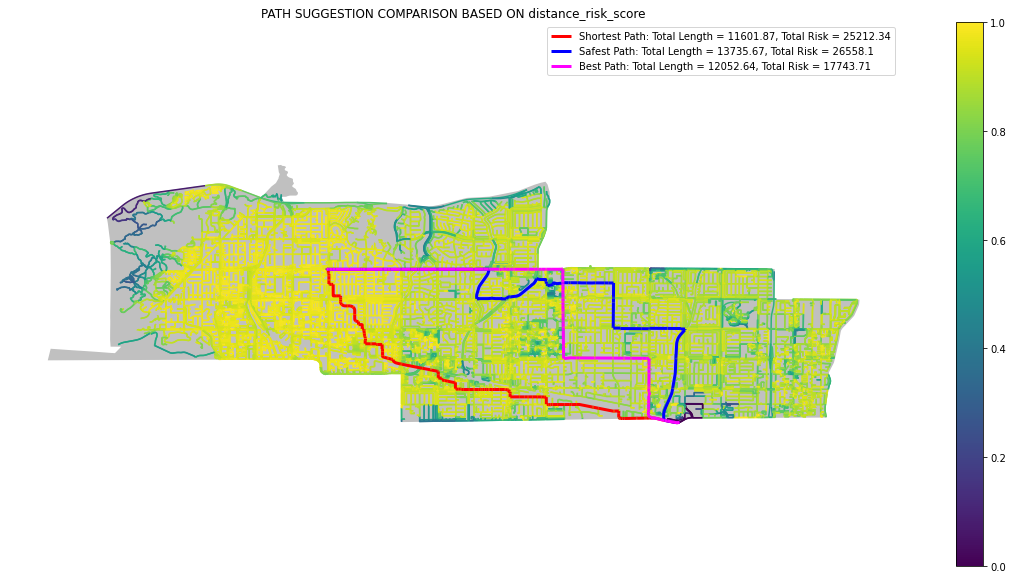

In [25]:
generateHeatmap(neighborhood, edges, shortest_path_edges, safest_path_edges, best_path_edges, column = 'distance_risk_score')

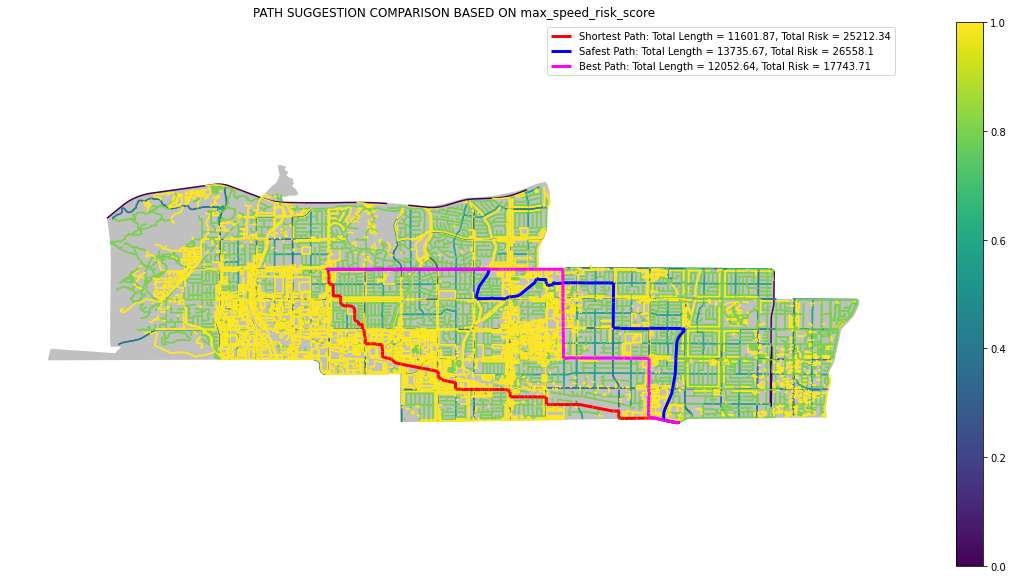

In [26]:
generateHeatmap(neighborhood, edges, shortest_path_edges, safest_path_edges, best_path_edges, column = 'max_speed_risk_score')

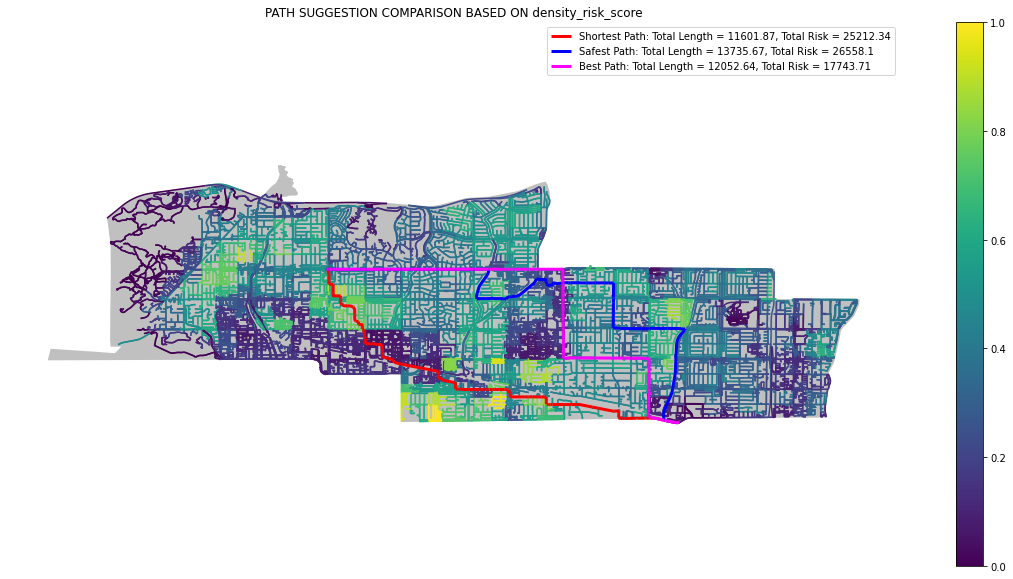

In [27]:
generateHeatmap(neighborhood, edges, shortest_path_edges, safest_path_edges, best_path_edges, column = 'density_risk_score')

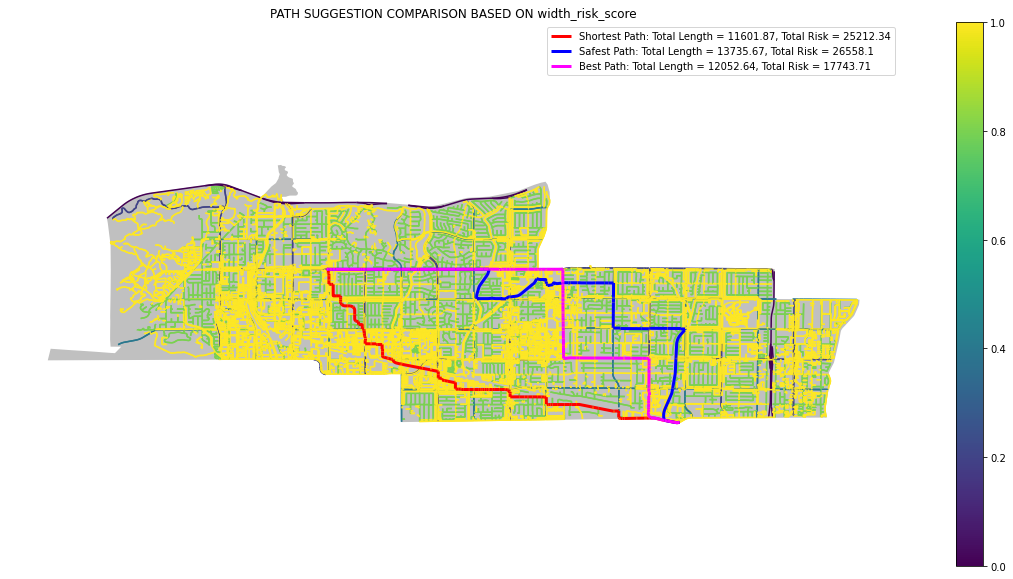

In [28]:
generateHeatmap(neighborhood, edges, shortest_path_edges, safest_path_edges, best_path_edges, column = 'width_risk_score')

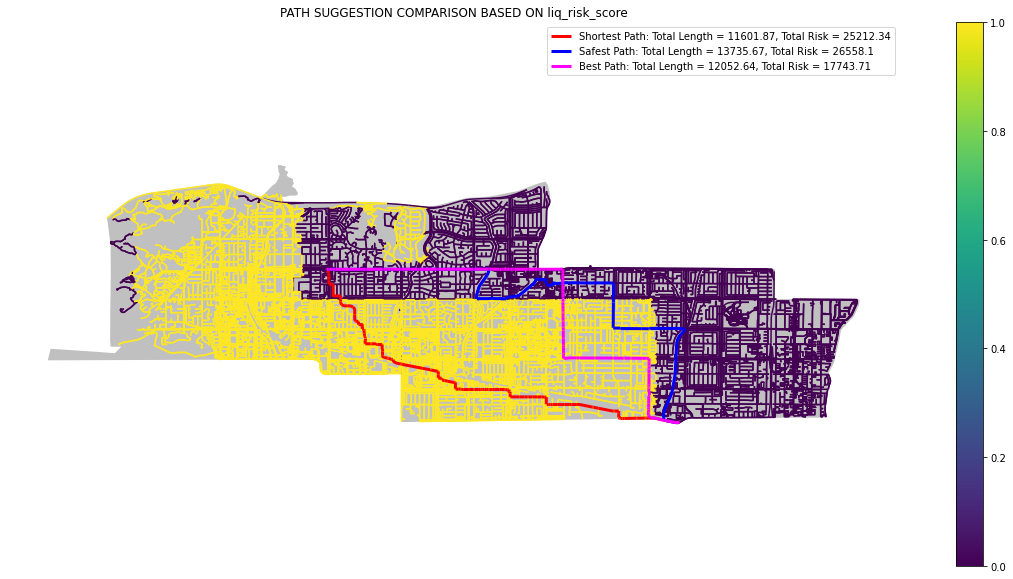

In [29]:
generateHeatmap(neighborhood, edges, shortest_path_edges, safest_path_edges, best_path_edges, column = 'liq_risk_score')

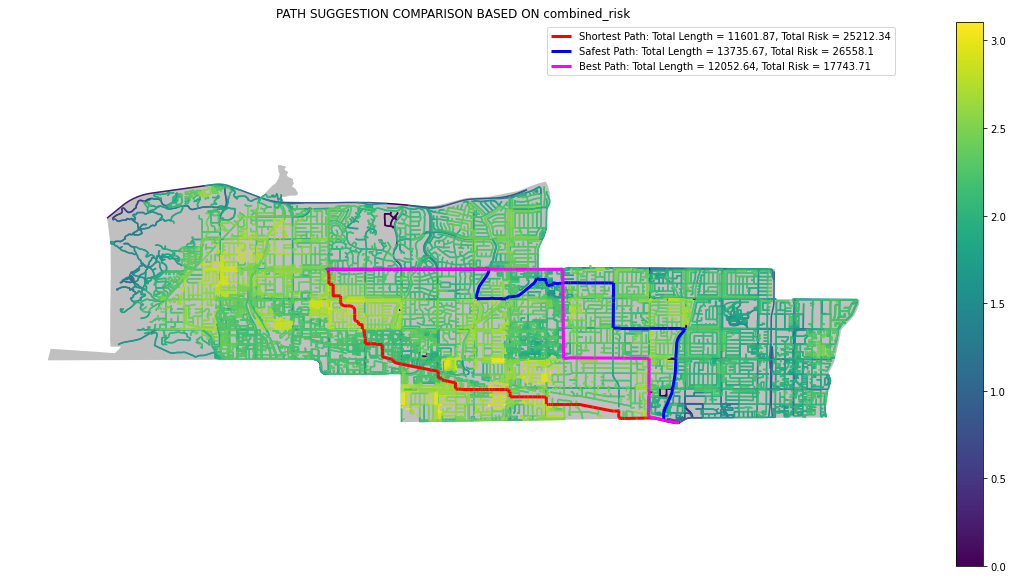

In [30]:
generateHeatmap(neighborhood, edges, shortest_path_edges, safest_path_edges, best_path_edges, column = 'combined_risk')